<a href="https://colab.research.google.com/github/Vioron/ds_belhard/blob/main/work03/work03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Блок 1 — Установка необходимых библиотек

In [29]:
# Установим зависимости.
!pip -q install requests sqlalchemy pandas tqdm matplotlib seaborn

# requests — простая и удобная библиотека для HTTP-запросов (GET/POST). Используется для скачивания данных с API и сайтов.
# sqlalchemy — высокоуровневая библиотека для работы с базами данных: умеет строить SQL, управлять соединениями и предоставляет ORM; подходит для SQLite/Postgres/MySQL и т.д.
# pandas — основная библиотека для работы с табличными данными (DataFrame): чтение/запись CSV, фильтрация, группировки, агрегаты и подготовка данных для анализа.
# tqdm — лёгкий индикатор прогресса: оборачивается вокруг циклов/итераторов и показывает progress-bar, удобно при скачивании или обработке многих записей.
# matplotlib — базовая библиотека для построения графиков (линии, гистограммы, scatter и т.д.); даёт полный контроль над видом рисунков.
# seaborn — надстройка над matplotlib для статистической визуализации: простые красивые графики (boxplot, violin, heatmap) и удобные темы по умолчанию.

###Блок 2 — Параметры и функции для скачивания данных

In [22]:
# Параметры: отрегулируйте CATEGORY, COUNTRY, PAGES при необходимости.
CATEGORY = "beverages"      # Пример: 'beverages', 'snacks', 'breakfasts' и т.д.
COUNTRY  = "Netherlands"    # Пример: 'Netherlands' или None для без фильтра по стране
PAGES    = 3                # Сколько страниц брать (page_size * pages ~ итоговый объём)
PAGE_SIZE= 1000             # Сколько записей за страницу (API поддерживает ~1000)

# Импортируем нужные библиотеки
import requests, time
import pandas as pd
from tqdm import tqdm

# Функция для постраничного скачивания поднабора продуктов из OpenFoodFacts API.
# Мы берём только ограниченное количество полей, чтобы не загружать всю "тяжёлую" JSON-структуру.
def fetch_off_products(category=None, country=None, page_size=PAGE_SIZE, pages=PAGES, sleep=0.3):
    rows = []
    for page in range(1, pages + 1):
        params = {
            "action": "process",
            "page_size": page_size,
            "page": page,
            "json": True
        }
        # Добавляем фильтр по категории, если задан
        if category:
            params.update({"tagtype_0": "categories", "tag_contains_0": "contains", "tag_0": category})
        # Добавляем фильтр по стране, если задан
        if country:
            params.update({"tagtype_1": "countries", "tag_contains_1": "contains", "tag_1": country})
        # Удаляем None-параметры
        params = {k: v for k, v in params.items() if v is not None}
        url = "https://world.openfoodfacts.org/cgi/search.pl"
        print(f"Requesting page {page} ...")
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        products = data.get("products", [])
        if not products:
            # если продуктов нет — заканчиваем досрочно
            print("No more products returned by API, stopping.")
            break
        for p in products:
            # Собираем только избранные поля, чтобы таблица была компактной
            rows.append({
                "code": p.get("code"),
                "product_name": p.get("product_name"),
                "brands": p.get("brands"),
                "countries": p.get("countries"),
                "categories": p.get("categories"),
                "categories_tags": p.get("categories_tags"),
                "ingredients_text": p.get("ingredients_text"),
                "additives_tags": p.get("additives_tags"),
                "allergens": p.get("allergens"),
                "nutriments": p.get("nutriments"),
                "serving_size": p.get("serving_size"),
                "created_t": p.get("created_t")
            })
        # Небольшая пауза между запросами, чтобы не перегружать API
        time.sleep(sleep)
    # Возвращаем pandas DataFrame
    return pd.DataFrame(rows)

# Запускаем скачивание
print("Start downloading OpenFoodFacts subset...")
df_raw = fetch_off_products(CATEGORY, COUNTRY, PAGE_SIZE, PAGES)
print("Downloaded rows:", len(df_raw))
# Покажем первые строки (если есть)
df_raw.head(5)


Start downloading OpenFoodFacts subset...
Requesting page 1 ...
Requesting page 2 ...
Requesting page 3 ...
Downloaded rows: 300


,code,product_name,brands,countries,categories,categories_tags,ingredients_text,additives_tags,allergens,nutriments,serving_size,created_t
0,5411188112709,Geröstete Mandel Ohne Zucker,Alpro,"Albânia,Áustria,Bélgica,Croácia,Finlândia,Fran...","en:Beverages and beverages preparations,Alimen...","[en:beverages-and-beverages-preparations, en:p...","Wasser, _Mandeln_ (2,3%), Calcium (Calciumcarb...","[en:e322, en:e412, en:e418]",en:nuts,"{'calcium': 0.12, 'calcium_100g': 0.12, 'calci...",1 serving (100 g),1427561633
1,8002270014901,S. Pellegrino Water,"Nestlé,Nestlé Waters,San Pellegrino","Belgio,Francia,Italia,Lussemburgo,Paesi Bassi,...","Bevande e preparati per bevande,Bevande,Bevand...","[en:beverages-and-beverages-preparations, en:b...",carbonated water 100%,[],,"{'bicarbonate': 0.252, 'bicarbonate_100g': 0.2...",None,1328993181
2,5060337220415,kefir drink original,Biotiful gut health,"France,Germany,Ireland,Netherlands,United Kingdom","Beverages and beverages preparations, Beverage...","[en:beverages-and-beverages-preparations, en:b...",Pasteurised Cow’s Milk fermented with Live Kef...,[],en:milk,"{'calcium': 0.111, 'calcium_100g': 0.0444, 'ca...",0.5 bottle (250 ml),1565349095
3,7394376616501,Haferdrink Barista,Oatly,"Austria, France, Germany, Netherlands, Poland,...","Getränke und Getränkezubereitungen, Pflanzlich...","[en:beverages-and-beverages-preparations, en:p...","Wasser, Hafer 10%, Rapsöl, Säureregulator (Dik...","[en:e340, en:e340ii]",en:gluten,"{'calcium': 0.12, 'calcium_100g': 0.12, 'calci...",100 ml,1517077643
4,5411188124702,"Alpro Haferdrink, Ungesüßt 1 L, FRESH","Alpro, Danone","Germany, Netherlands, Spain, United Kingdom, e...","Getränke und Getränkezubereitungen, Pflanzlich...","[en:beverages-and-beverages-preparations, en:p...","oat base (97,1%) (water, oat (8,3%]), chicory ...",[en:e418],en:gluten,"{'calcium': 0.12, 'calcium_100g': 0.12, 'calci...",1 portion (100 ml),1563025039


###Блок 3 — Предобработка: извлечение нутриентов, флаги аллергенов, palm oil и т.д.

In [24]:
# Предобработка: извлекаем полезные признаки в удобном формате для SQL и графиков.
import re
import numpy as np

# Копируем исходные данные
df = df_raw.copy()

# 1) Очищаем бренд: берем первый элемент из 'brands' (часто это строка "Brand1, Brand2")
df['brand_clean'] = df['brands'].fillna('').str.split(',').str[0].str.strip().replace('', None)

# 2) Помощник для извлечения значения из словаря nutriments
def get_nutr(n, key):
    if isinstance(n, dict):
        return n.get(key)
    return None

# 3) Извлекаем наиболее важные нутриенты (если их нет — None)
df['sugars_100g'] = df['nutriments'].apply(lambda n: get_nutr(n, 'sugars_100g'))
df['salt_100g']   = df['nutriments'].apply(lambda n: get_nutr(n, 'salt_100g'))
# energy может называться 'energy-kcal_100g' или 'energy_100g' (джоули)
df['energy_kcal_100g'] = df['nutriments'].apply(lambda n: get_nutr(n, 'energy-kcal_100g') or get_nutr(n, 'energy_100g'))
df['fat_100g'] = df['nutriments'].apply(lambda n: get_nutr(n, 'fat_100g'))

# 4) additives_count — сколько добавок указано
df['additives_count'] = df['additives_tags'].apply(lambda v: len(v) if isinstance(v, list) else 0)

# 5) ingredients_count — грубая оценка: count по запятым/точкам с запятой/переносам
df['ingredients_count'] = df['ingredients_text'].fillna('').apply(lambda s: len([x for x in re.split(r',|;|\n', s) if x.strip()]))

# 6) contains_palm_oil — ищем подстроку 'palm' в ingredients_text или additives_tags
def detect_palm(row):
    ing = (row.get('ingredients_text') or '').lower()
    if 'palm' in ing:
        return True
    adds = row.get('additives_tags')
    if isinstance(adds, list):
        for a in adds:
            if 'palm' in a.lower():
                return True
    return False

df['contains_palm_oil'] = df.apply(detect_palm, axis=1)

# 7) Флаги аллергенов — проверяем в ingredients_text наличие слов-аллергенов
ALLERGENS = ['milk','soy','gluten','nuts','egg','fish','sesame','peanut','almond','hazelnut','walnut']
def allergen_flags(text):
    t = (text or '').lower()
    return {f"allergen_{a}": (a in t) for a in ALLERGENS}

all_flags = df['ingredients_text'].apply(allergen_flags).apply(pd.Series)
df = pd.concat([df, all_flags], axis=1)

# 8) created_dt и created_ym — преобразуем timestamp в datetime и период YYYY-MM
df['created_t'] = pd.to_numeric(df['created_t'], errors='coerce')
df['created_dt'] = pd.to_datetime(df['created_t'], unit='s', errors='coerce')
df['created_ym'] = df['created_dt'].dt.to_period('M').astype(str)

# 9) main_category — берем первую часть поля categories до первой запятой (чтобы группировать по "основной" категории)
def get_main_category(cat):
    if not isinstance(cat, str) or not cat.strip():
        return None
    parts = [p.strip() for p in cat.split(',') if p.strip()]
    return parts[0] if parts else None

df['main_category'] = df['categories'].apply(get_main_category)

# 10) Выбираем итоговые колонки и приводим числовые поля к numeric
cols_to_keep = [
    'code','product_name','brand_clean','countries','categories','main_category','categories_tags',
    'sugars_100g','salt_100g','energy_kcal_100g','fat_100g',
    'serving_size','created_dt','created_ym',
    'additives_count','ingredients_count','contains_palm_oil'
] + [f"allergen_{a}" for a in ALLERGENS]

df_clean = df[cols_to_keep].copy()

# Приводим числовые колонки к числам (float)
num_cols = ['sugars_100g','salt_100g','energy_kcal_100g','fat_100g','additives_count','ingredients_count']
for c in num_cols:
    df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')

# Преобразуем categories_tags в строку (если это список) для удобства хранения в SQLite
df_clean['categories_tags'] = df['categories_tags'].apply(lambda v: ','.join(v) if isinstance(v, list) else None)

print("Preprocessing finished. Rows:", len(df_clean))
df_clean.head(5)


Preprocessing finished. Rows: 300


,code,product_name,brand_clean,countries,categories,main_category,categories_tags,sugars_100g,salt_100g,energy_kcal_100g,...,allergen_soy,allergen_gluten,allergen_nuts,allergen_egg,allergen_fish,allergen_sesame,allergen_peanut,allergen_almond,allergen_hazelnut,allergen_walnut
0,5411188112709,Geröstete Mandel Ohne Zucker,Alpro,"Albânia,Áustria,Bélgica,Croácia,Finlândia,Fran...","en:Beverages and beverages preparations,Alimen...",en:Beverages and beverages preparations,"en:beverages-and-beverages-preparations,en:pla...",0.0,0.150,15.0000,...,False,False,False,False,False,False,False,False,False,False
1,8002270014901,S. Pellegrino Water,Nestlé,"Belgio,Francia,Italia,Lussemburgo,Paesi Bassi,...","Bevande e preparati per bevande,Bevande,Bevand...",Bevande e preparati per bevande,"en:beverages-and-beverages-preparations,en:bev...",0.0,0.000,0.0001,...,False,False,False,False,False,False,False,False,False,False
2,5060337220415,kefir drink original,Biotiful gut health,"France,Germany,Ireland,Netherlands,United Kingdom","Beverages and beverages preparations, Beverage...",Beverages and beverages preparations,"en:beverages-and-beverages-preparations,en:bev...",2.8,0.098,59.2000,...,False,False,False,False,False,False,False,False,False,False
3,7394376616501,Haferdrink Barista,Oatly,"Austria, France, Germany, Netherlands, Poland,...","Getränke und Getränkezubereitungen, Pflanzlich...",Getränke und Getränkezubereitungen,"en:beverages-and-beverages-preparations,en:pla...",3.4,0.100,61.0000,...,False,False,False,False,False,False,False,False,False,False
4,5411188124702,"Alpro Haferdrink, Ungesüßt 1 L, FRESH",Alpro,"Germany, Netherlands, Spain, United Kingdom, e...","Getränke und Getränkezubereitungen, Pflanzlich...",Getränke und Getränkezubereitungen,"en:beverages-and-beverages-preparations,en:pla...",0.0,0.110,40.0000,...,False,True,False,False,False,False,False,False,False,False


###Блок 4 — Сохранение в локальную SQLite базу (Colab-friendly) и быстрая проверка

In [25]:
# Сохраняем предобработанный набор в локальную SQLite базу, чтобы выполнять SQL-запросы через SQLAlchemy/pandas
from sqlalchemy import create_engine, text
import os

SQLITE_PATH = "/content/off_food.db"
engine = create_engine(f"sqlite:///{SQLITE_PATH}", echo=False)

# Сохраняем таблицу (если уже есть — заменяем)
df_clean.to_sql('off_products', engine, if_exists='replace', index=False)
print("Saved preprocessed data to SQLite:", SQLITE_PATH)

# Быстрая проверка: сколько строк в таблице
with engine.connect() as conn:
    count = conn.execute(text("SELECT COUNT(*) FROM off_products")).scalar()
print("Rows in SQLite table off_products:", count)


Saved preprocessed data to SQLite: /content/off_food.db
Rows in SQLite table off_products: 300


###Блок 5 — Примеры SQL-запросов (через pandas) — агрегации и фильтры

In [26]:
# Примеры SQL-агрегаций: среднее сахара по main_category, топ брендов по добавкам и т.д.
import pandas as pd
from sqlalchemy import text

with engine.connect() as conn:
    # 1) Среднее сахара и количество по основной категории (main_category)
    q1 = """
        SELECT main_category,
               COUNT(*) AS cnt,
               AVG(sugars_100g) AS avg_sugar
        FROM off_products
        WHERE sugars_100g IS NOT NULL AND main_category IS NOT NULL
        GROUP BY main_category
        HAVING cnt >= 5
        ORDER BY avg_sugar DESC
        LIMIT 20;
    """
    df_q1 = pd.read_sql(q1, conn)
    print("Top categories by average sugar:")
    print(df_q1.head(10))

    # 2) Топ брендов по средней additives_count (только бренды с >=10 товаров)
    q2 = """
        SELECT brand_clean,
               COUNT(*) AS cnt,
               AVG(additives_count) AS avg_additives
        FROM off_products
        WHERE brand_clean IS NOT NULL
        GROUP BY brand_clean
        HAVING cnt >= 10
        ORDER BY avg_additives DESC
        LIMIT 20;
    """
    df_q2 = pd.read_sql(q2, conn)
    print("\nTop brands by avg additives_count:")
    print(df_q2.head(10))

    # 3) Процент продуктов, содержащих palm oil по основным категориям
    q3 = """
        SELECT main_category,
               COUNT(*) AS cnt,
               SUM(CASE WHEN contains_palm_oil THEN 1 ELSE 0 END) AS cnt_palm,
               100.0 * SUM(CASE WHEN contains_palm_oil THEN 1 ELSE 0 END) / COUNT(*) AS pct_palm
        FROM off_products
        WHERE main_category IS NOT NULL
        GROUP BY main_category
        HAVING cnt >= 30
        ORDER BY pct_palm DESC
        LIMIT 20;
    """
    df_q3 = pd.read_sql(q3, conn)
    print("\nPalm oil prevalence by main_category:")
    print(df_q3.head(10))

    # 4) Распространённость аллергенов (суммарно по таблице)
    q4 = """
        SELECT
            SUM(CASE WHEN allergen_milk THEN 1 ELSE 0 END) AS milk_cnt,
            SUM(CASE WHEN allergen_soy THEN 1 ELSE 0 END) AS soy_cnt,
            SUM(CASE WHEN allergen_gluten THEN 1 ELSE 0 END) AS gluten_cnt,
            COUNT(*) AS total
        FROM off_products;
    """
    df_q4 = pd.read_sql(q4, conn)
    print("\nAllergen counts (summary):")
    print(df_q4.T)

# Результаты доступны как pandas DataFrame: df_q1, df_q2, df_q3, df_q4


Top categories by average sugar:
                             main_category  cnt  avg_sugar
0                                Beverages   26  15.705769
1     Beverages and beverages preparations   32  12.622250
2   Plantaardige levensmiddelen en dranken   26   9.000000
3  Aliments et boissons à base de végétaux   21   6.300000
4     Boissons et préparations de boissons   14   5.292857
5       Getränke und Getränkezubereitungen   18   4.326389
6          Plant-based foods and beverages   22   4.225000
7                                  Dranken   22   3.537727
8              Dranken en drankbereidingen   19   3.389474
9                                 Boissons   12   3.050000

Top brands by avg additives_count:
    brand_clean  cnt  avg_additives
0        Lipton   11       2.545455
1         Alpro   14       2.428571
2     Coca-Cola   11       1.727273
3  Albert Heijn   13       1.461538

Palm oil prevalence by main_category:
                            main_category  cnt  cnt_palm  pct_p

Блок 6 — Визуализации (Matplotlib + Seaborn)

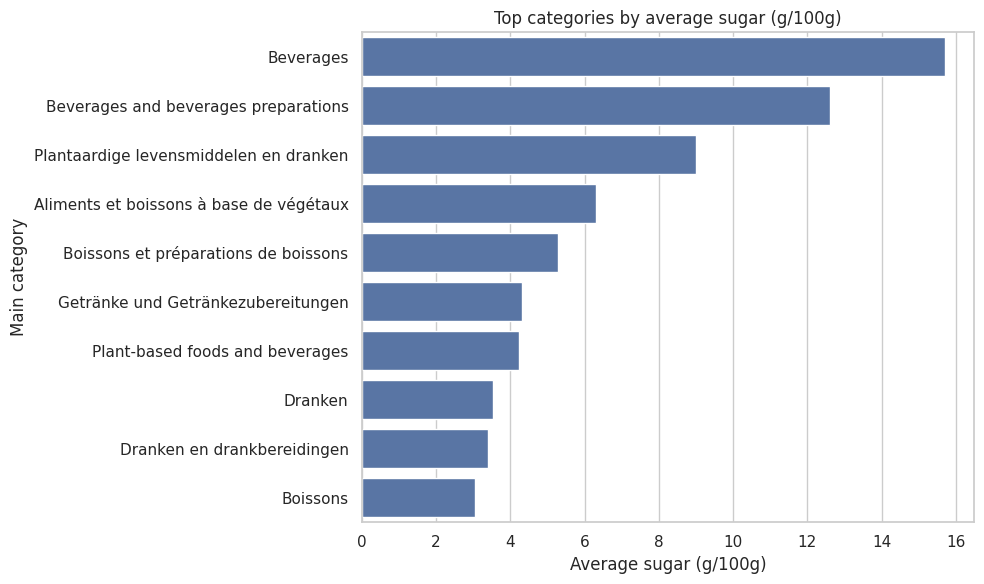

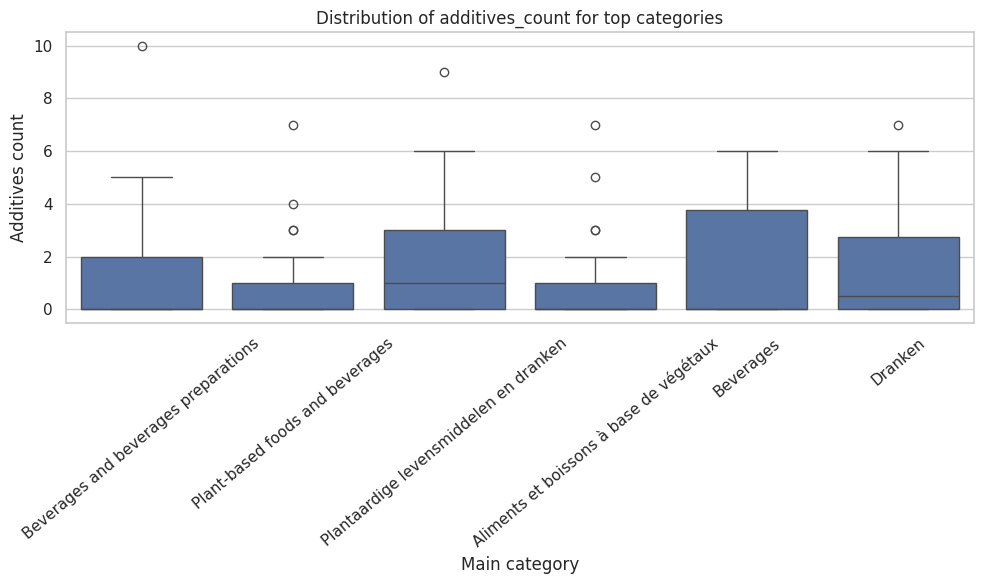

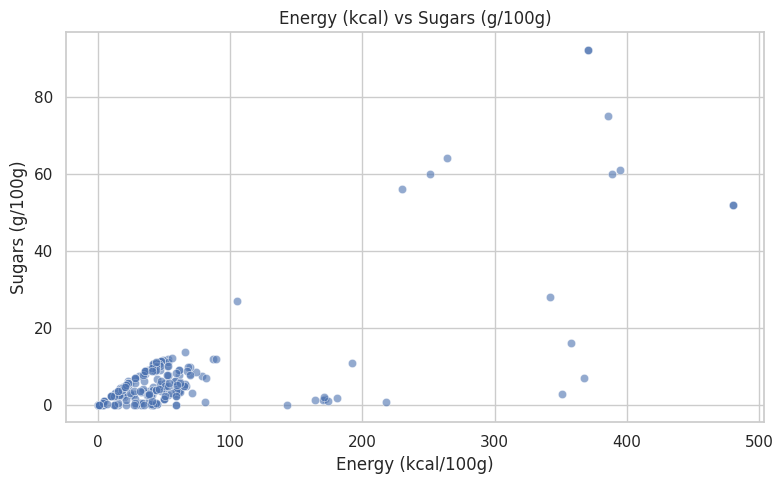

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# 1) Bar: топ категорий по среднему сахару (из df_q1)
if not df_q1.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_q1, x='avg_sugar', y='main_category')
    plt.title('Top categories by average sugar (g/100g)')
    plt.xlabel('Average sugar (g/100g)')
    plt.ylabel('Main category')
    plt.tight_layout()
    plt.show()

# 2) Boxplot: распределение additives_count для топ-6 категорий по количеству записей
df_box = pd.read_sql("""
    SELECT main_category, additives_count
    FROM off_products
    WHERE main_category IS NOT NULL AND additives_count IS NOT NULL
""", engine)
top_cats = df_box['main_category'].value_counts().nlargest(6).index.tolist()
plt.figure(figsize=(10,6))
sns.boxplot(data=df_box[df_box['main_category'].isin(top_cats)], x='main_category', y='additives_count')
plt.title('Distribution of additives_count for top categories')
plt.xlabel('Main category')
plt.ylabel('Additives count')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

# 3) Scatter: sugar vs energy (sample для скорости)
df_scatter = pd.read_sql("SELECT sugars_100g, energy_kcal_100g FROM off_products WHERE sugars_100g IS NOT NULL AND energy_kcal_100g IS NOT NULL LIMIT 1000", engine)
if not df_scatter.empty:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df_scatter, x='energy_kcal_100g', y='sugars_100g', alpha=0.6)
    plt.title('Energy (kcal) vs Sugars (g/100g)')
    plt.xlabel('Energy (kcal/100g)')
    plt.ylabel('Sugars (g/100g)')
    plt.tight_layout()
    plt.show()
